In [1]:
import pandas as pd
import os
import random
import openslide
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset
import torch
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision import transforms

In [2]:
DATA_DIR = 'Data/'

args = pd.Series({
    'batch_size_per_gpu' : 16,
    'num_workers': 4,
    'image_dir': os.path.join(DATA_DIR, 'train_images'),
})

Use as much augmentation as possible to help generalise the model

### Data loader

Develop dataset and loader to load model and apply transforms with PyTorch

In [3]:
patch_df = pd.read_csv('train_patches.csv', index_col=0)

train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_hot.csv'), index_col=0)

In [4]:
train_df.head()

image_id label  image_width  image_height  is_tma  label_cat  is_tma_hot
0         4  HGSC        23785         20008   False          5           0
1        66  LGSC        48871         48195   False          2           0
2        91  HGSC         3388          3388    True          5           1
3       281  LGSC        42309         15545   False          2           0
4       286    EC        37204         30020   False          3           0

In [5]:
def label_for_id(image_id, label_df):
    return label_df[label_df['image_id']==image_id]['label_cat'].iloc[0]

In [6]:
class PatchDataset(Dataset):
    def __init__(self, patch_df, label_df, image_folder, transform=None, patch_size=256):
        self.patch_df = patch_df
        self.label_df = label_df
        self.image_folder = image_folder
        self.transform = transform
        self.patch_size = patch_size
        
        
    def __len__(self):
        return len(self.patch_df)
    
    
    def __getitem__(self, idx):
        patch_info = self.patch_df.loc[idx] # using loc, so using name of index not ordered position
        x, y = patch_info['x_coord'], patch_info['y_coord']
        image_id = patch_info['image_id']
        
        wsi = openslide.OpenSlide(os.path.join(self.image_folder, f"{image_id}.tif"))
        wsi_size = wsi.dimensions
        
        patch = wsi.read_region((x, y), level=0, size=(self.patch_size, self.patch_size))
        patch = np.array(patch)[..., :3]
        
        
        # shape torch.Size([batch_size, 256, 256, 3])
        
        if self.transform is not None:
            pil_img = Image.fromarray(patch)
            patch = self.transform(pil_img) # pil_img
        
        label = self.label_for_id(image_id)
        
        return patch, label
    
        
    def label_for_id(self, image_id):
        return self.label_df[self.label_df['image_id']==image_id]['label_cat'].iloc[0]
        

Visualise examples without transforms

In [7]:
patch_dataset = PatchDataset(patch_df=patch_df, label_df=train_df, 
                             image_folder=args.image_dir, transform=None)
        
patch_loader = torch.utils.data.DataLoader(patch_dataset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)


patch_subset = PatchDataset(patch_df=patch_df.iloc[:1000], label_df=train_df, 
                             image_folder=args.image_dir, transform=None)
        
patch_loader = torch.utils.data.DataLoader(patch_subset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

In [8]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        print(img.size)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def show_arr(imgs):
    fig, axs = plt.subplots(ncols=imgs.shape[0], squeeze=False, figsize=(20,20))
    for i in range(imgs.shape[0]):
        img = imgs[i, :]
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [9]:
for i, (img, lbl) in enumerate(patch_loader):
    print(img.shape)
    if i == 0:
        break

torch.Size([16, 256, 256, 3])


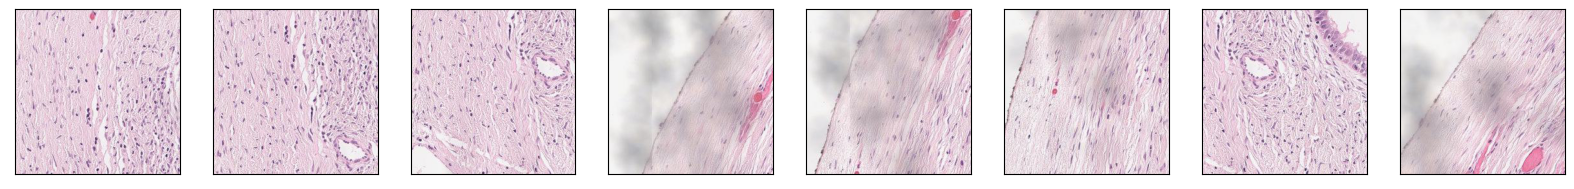

In [10]:
show_arr(img[:8, :])

Visualise examples with transforms

In [50]:
class MyRotateTransform:
    def __init__(self, angles):  #: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)
    
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

more_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(9, 9)),
    transforms.RandomPosterize(bits=2),
    transforms.RandomAdjustSharpness(sharpness_factor=2., p=0.2),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomEqualize(p=0.3),
    MyRotateTransform(angles=[-90, 0, 90, 180]),
    transforms.ToTensor(),
])

colour_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.1, 0.05, 0, 0.1),
    transforms.GaussianBlur(kernel_size=(9, 9)),
    transforms.RandomAdjustSharpness(sharpness_factor=2., p=0.2),
    transforms.RandomAutocontrast(p=0.5),
    MyRotateTransform(angles=[-90, 0, 90, 180]),
    transforms.ToTensor(),
])

more_colour_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(.1, 0.25, 0.5, 0.25),
    transforms.GaussianBlur(kernel_size=(9, 9)),
    transforms.RandomAdjustSharpness(sharpness_factor=2., p=0.2),
    transforms.RandomAutocontrast(p=0.5),
    MyRotateTransform(angles=[-90, 0, 90, 180]),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(.1, 0.25, 0.5, 0.25),
    transforms.GaussianBlur(kernel_size=(9, 9)),
    transforms.RandomAdjustSharpness(sharpness_factor=2., p=0.2),
    transforms.RandomAutocontrast(p=0.5),
    MyRotateTransform(angles=[-90, 0, 90, 180]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Simple transforms: resize, random flip

torch.Size([16, 3, 224, 224])
(1810, 454)


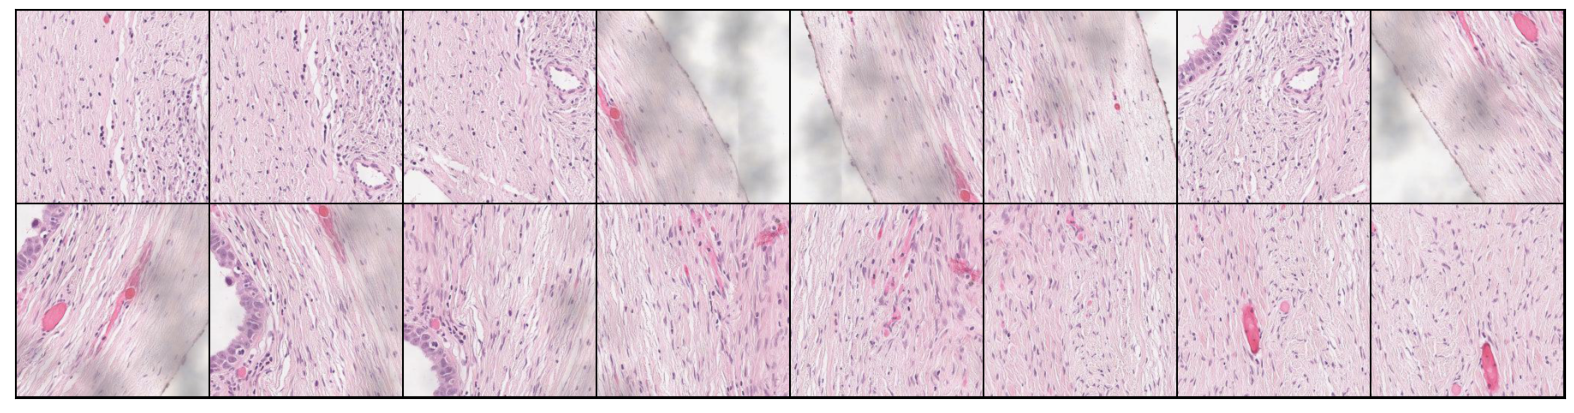

In [12]:
patch_subset = PatchDataset(patch_df=patch_df.iloc[:1000], label_df=train_df, 
                             image_folder=args.image_dir, transform=simple_transform)
        
patch_loader = torch.utils.data.DataLoader(patch_subset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

for i, (img, lbl) in enumerate(patch_loader):
    print(img.shape)
    if i == 0:
        break
        
grid=make_grid(img[:16])
show(grid)

More transforms: add blur, posterize, sharpness, contrast, histogram euqalize, rotation

torch.Size([16, 3, 224, 224])
(1810, 454)


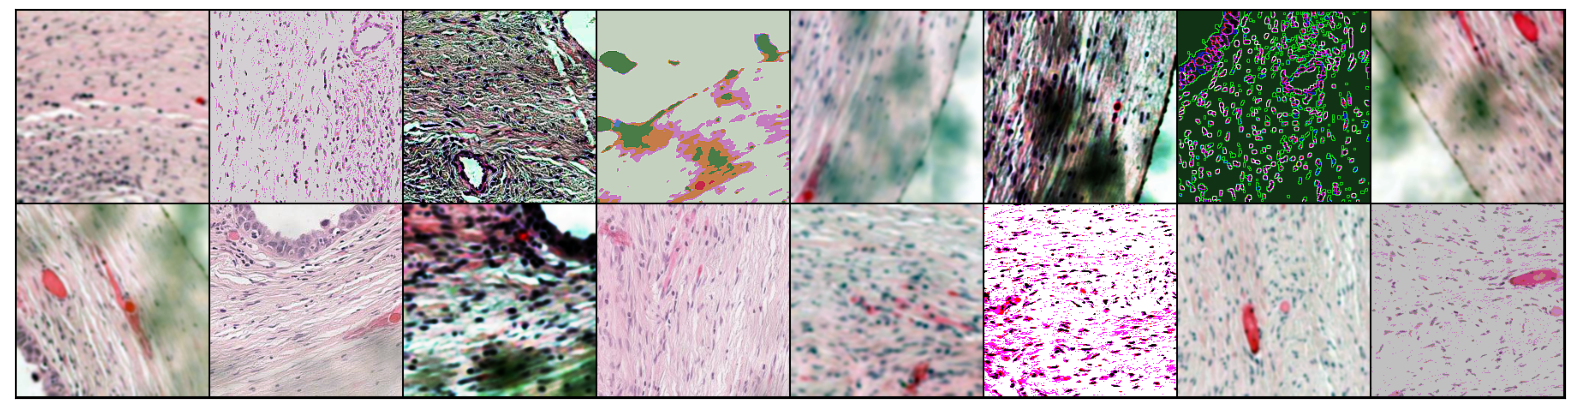

In [14]:
patch_subset = PatchDataset(patch_df=patch_df.iloc[:1000], label_df=train_df, 
                             image_folder=args.image_dir, transform=more_transform)
        
patch_loader = torch.utils.data.DataLoader(patch_subset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

for i, (img, lbl) in enumerate(patch_loader):
    print(img.shape)
    if i == 0:
        break
        
grid=make_grid(img[:16])
show(grid)

Colour transform: add colour jitter (still no normalisation)

Remove posterise and equalise

torch.Size([16, 3, 224, 224])
(1810, 454)


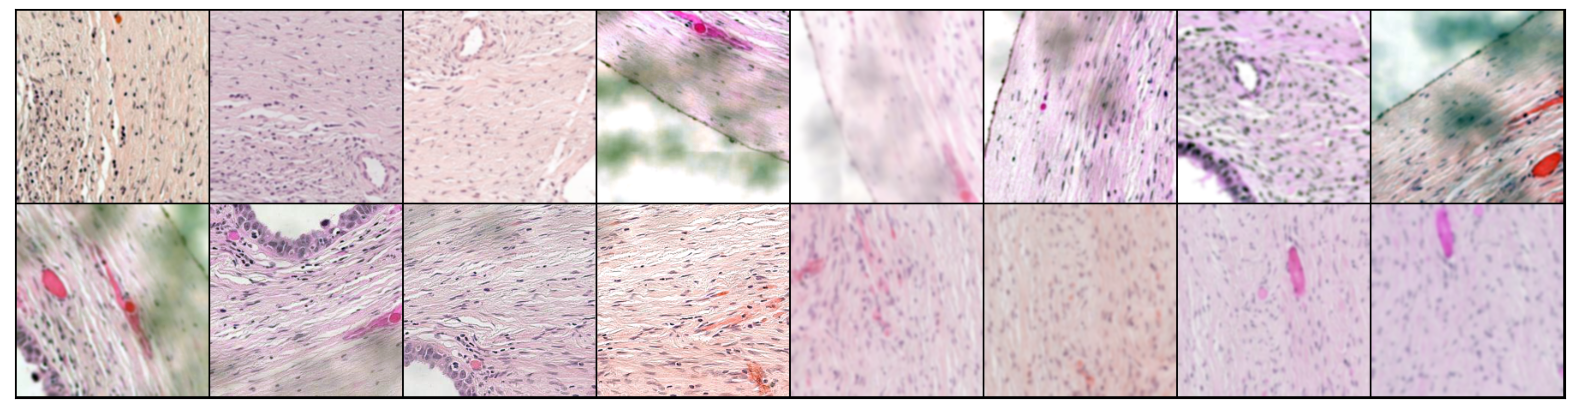

In [34]:
patch_subset = PatchDataset(patch_df=patch_df.iloc[:1000], label_df=train_df, 
                             image_folder=args.image_dir, transform=colour_transform)
        
patch_loader = torch.utils.data.DataLoader(patch_subset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

for i, (img, lbl) in enumerate(patch_loader):
    print(img.shape)
    if i == 0:
        break
        
grid=make_grid(img[:16])
show(grid)

More severe colour jitter

torch.Size([16, 3, 224, 224])
(1810, 454)


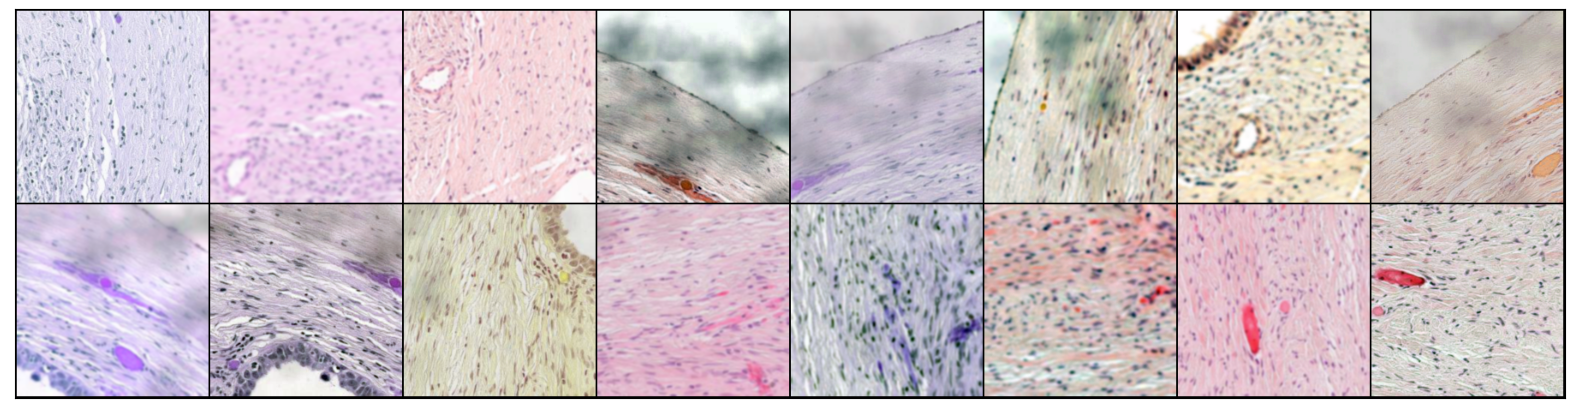

In [49]:
patch_subset = PatchDataset(patch_df=patch_df.iloc[:1000], label_df=train_df, 
                             image_folder=args.image_dir, transform=more_colour_transform)
        
patch_loader = torch.utils.data.DataLoader(patch_subset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

for i, (img, lbl) in enumerate(patch_loader):
    print(img.shape)
    if i == 0:
        break
        
grid=make_grid(img[:16])
show(grid)

Above plus normalize

torch.Size([16, 3, 224, 224])
(1810, 454)


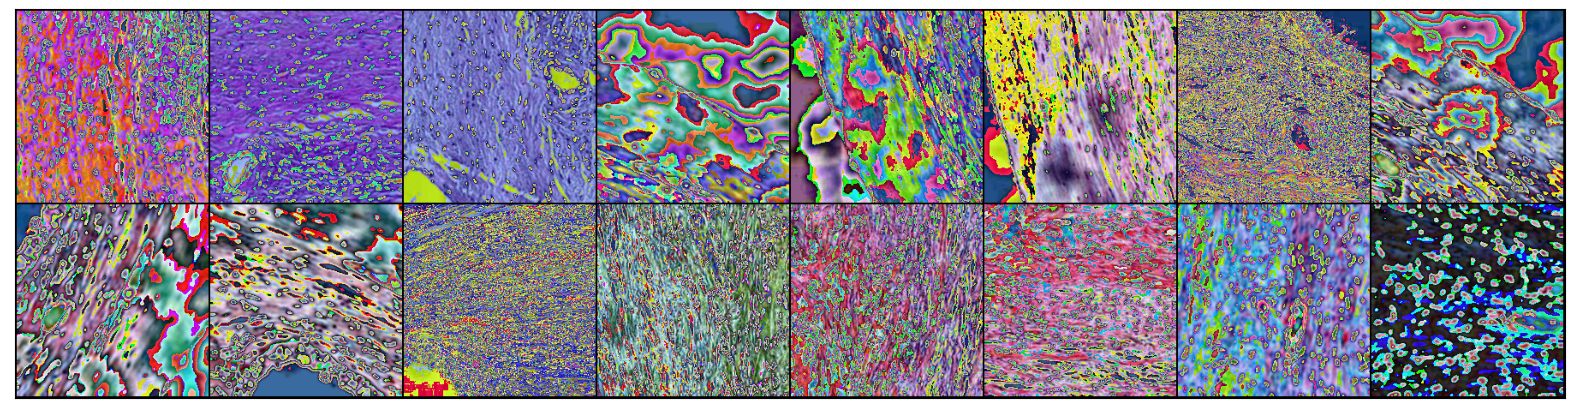

In [51]:
patch_subset = PatchDataset(patch_df=patch_df.iloc[:1000], label_df=train_df, 
                             image_folder=args.image_dir, transform=train_transform)
        
patch_loader = torch.utils.data.DataLoader(patch_subset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

for i, (img, lbl) in enumerate(patch_loader):
    print(img.shape)
    if i == 0:
        break
        
grid=make_grid(img[:16])
show(grid)

### Transforms to use

In [52]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(.1, 0.25, 0.5, 0.25),
    transforms.GaussianBlur(kernel_size=(9, 9)),
    transforms.RandomAdjustSharpness(sharpness_factor=2., p=0.2),
    transforms.RandomAutocontrast(p=0.5),
    MyRotateTransform(angles=[-90, 0, 90, 180]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])